# Bounding box detection - Racoon data


## Data files
- images_racoon.zip: contain images of racoons
- train_labels.csv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [2]:
# import the required libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from matplotlib import patches
from tensorflow.keras.backend import epsilon
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.vgg16 import  VGG16, preprocess_input 
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Reshape,Conv1D,GlobalAveragePooling2D, RepeatVector, Flatten
from tensorflow.keras.utils import plot_model


### Mount to drive

In [3]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Change directory

In [4]:
# setting the directory
os.chdir('/content/drive/MyDrive/R10_Internal_Lab')

In [5]:
os.getcwd()

'/content/drive/MyDrive/R10_Internal_Lab'

### Load the training data from train.csv file

In [6]:
# loading the dataset
df_racoon = pd.read_csv('/content/drive/MyDrive/R10_Internal_Lab/train_labels.csv')

### Print the shape of the train dataset

In [7]:
# checking the shape of the dataset
df_racoon.shape

(173, 8)

In [8]:
df_racoon.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [9]:
# setting the shape for the images to 128 *128
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width and height, x0, y0, x1, y1 in individual variables. <br>
1. Create a list variable known as 'paths' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be resized to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [10]:
# storing the paths of the images
paths=[]

# getting the coordinates of the boundary boxes
coords = np.zeros((df_racoon.shape[0],4))

# iterating the dataset to get all the image path and coordinates
for i,row in df_racoon.iterrows():
  #print(row)
  paths.append(row['filename'])
  coords[i,0] = row['xmin']* IMAGE_SIZE /row['width']
  coords[i,1] = row['ymin']* IMAGE_SIZE /row['height']
  coords[i,2] = row['xmax']* IMAGE_SIZE /row['width']
  coords[i,3] = row['ymax']* IMAGE_SIZE /row['height']


In [11]:
# checking the obtained path
paths[:25]

['raccoon-17.jpg',
 'raccoon-11.jpg',
 'raccoon-63.jpg',
 'raccoon-63.jpg',
 'raccoon-60.jpg',
 'raccoon-69.jpg',
 'raccoon-180.jpg',
 'raccoon-200.jpg',
 'raccoon-141.jpg',
 'raccoon-19.jpg',
 'raccoon-84.jpg',
 'raccoon-124.jpg',
 'raccoon-182.jpg',
 'raccoon-111.jpg',
 'raccoon-91.jpg',
 'raccoon-79.jpg',
 'raccoon-93.jpg',
 'raccoon-20.jpg',
 'raccoon-42.jpg',
 'raccoon-139.jpg',
 'raccoon-58.jpg',
 'raccoon-71.jpg',
 'raccoon-183.jpg',
 'raccoon-1.jpg',
 'raccoon-169.jpg']

In [12]:
#checking the obtained coordinates
coords[:25]

array([[ 46.94980695,  39.58762887,  82.53281853,  77.8556701 ],
       [  0.58181818,   0.2962963 ,  89.40606061, 127.7037037 ],
       [ 15.78666667,  34.24      ,  59.73333333,  92.8       ],
       [ 48.42666667,  29.76      ,  85.97333333,  95.36      ],
       [ 27.19413919,  22.83243243,  92.36630037,  87.87027027],
       [  7.49268293,   5.72357724, 117.38536585, 124.87804878],
       [ 25.38666667,   6.72      ,  78.50666667, 127.68      ],
       [ 52.47509579,   6.63212435, 122.11494253, 110.09326425],
       [  0.51405622,   0.63366337,  79.16465863, 111.52475248],
       [ 42.996139  ,   5.27835052,  89.94594595,  58.72164948],
       [ 13.09570957,   4.62650602,  83.22112211, 125.68674699],
       [  8.4015444 ,  25.73195876, 118.11583012,  96.98969072],
       [  4.352     ,  31.232     ,  71.424     , 127.744     ],
       [  6.83333333,   0.66666667, 113.83333333, 122.26666667],
       [ 11.93220339,   5.70700637, 117.15254237, 125.55414013],
       [ 24.        ,   0

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [13]:
# loading the training images
batch_images = np.zeros((len(paths),IMAGE_SIZE, IMAGE_SIZE,3), dtype=np.float32)

In [14]:
# opening all the images and converting into RCB channel
for i,img in enumerate(paths):
  img_ip = Image.open('images/' + img)
  img_ip = img_ip.resize((IMAGE_SIZE, IMAGE_SIZE))
  img_ip = img_ip.convert(('RGB'))
  batch_images[i] = preprocess_input(np.array(img_ip, dtype = np.float32))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


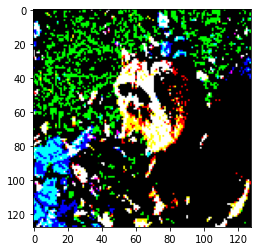

In [15]:
# visualize image
import matplotlib.pyplot as plt
plt.imshow(batch_images[137])

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3.
### Freeze all the layers and Add convolution layers and reshape layers at the end to ensure the output has 4 coordinates.

In [20]:
# getting the mobilenet model
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False)

In [21]:
# freezing all the layers
for layer in model.layers:
  layer.trainable = False

In [22]:
# adding convolution layers and reshape
x = model.layers[-1].output
x= Conv2D(4, kernel_size=4)(x)
x = Reshape((4,))(x)
model = Model(inputs=model.input, outputs=x)

## Plot the model and view the whole skeleton using plot_model.

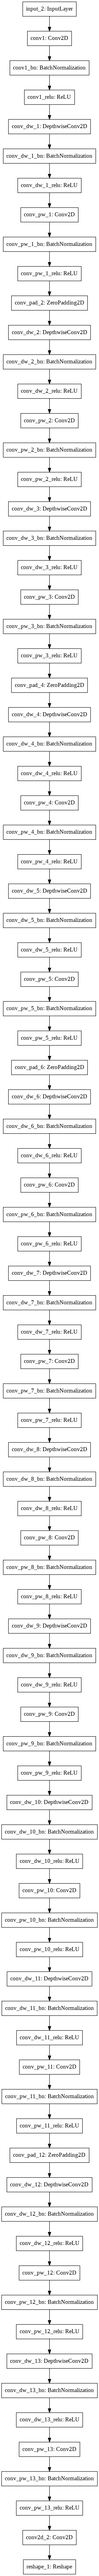

In [23]:
# plotting the model 
plot_model(model)

### Define a custom loss function IoU which calculates Intersection Over Union

In [24]:
# custom loss function
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

# function to get IoU
def IoU(y_true, y_pred):
    iou = tf.compat.v1.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [25]:
# compile the model
model.compile(optimizer='Adam', loss='mse',  metrics=[IoU])

In [26]:
# fit the model
model.fit(batch_images, coords, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
6/6 [==============================] - 31s 92ms/step - loss: 4161.8198 - IoU: 0.0713
Epoch 2/30
6/6 [==============================] - 0s 32ms/step - loss: 970.9467 - IoU: 0.3734
Epoch 3/30
6/6 [==============================] - 0s 31ms/step - loss: 383.4570 - IoU: 0.5739
Epoch 4/30
6/6 [===========================

### Pick a test image from the given data

In [27]:
# taking a random image to test 
test_img = Image.open('/content/drive/MyDrive/R10_Internal_Lab/images/raccoon-10.jpg')

# to get the original image
unscaled = Image.open('/content/drive/MyDrive/R10_Internal_Lab/images/raccoon-10.jpg')

In [28]:
# setting the image weight and height
image_width = unscaled.size[0]
image_height = unscaled.size[1]

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [29]:
# resize the test image for the MobileNet model
test_img = test_img.resize((IMAGE_SIZE, IMAGE_SIZE))
test_img = test_img.convert(('RGB'))
test_img = preprocess_input(np.array(test_img, dtype = np.float32))

### Predict the coordinates of the bounding box for the given test image

In [30]:
# predictin the coordinates for the boundar box
region = model.predict(np.array([test_img]))

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

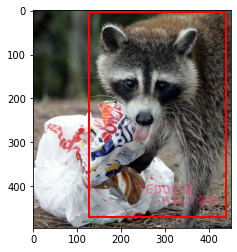

In [31]:
x0 = int(region[0][0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[0][1] * image_height / IMAGE_SIZE)

x1 = int((region[0][2]) * image_width / IMAGE_SIZE)
y1 = int((region[0][3]) * image_height / IMAGE_SIZE)


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()


# VGG16 Implementation

# VGG 16 Implementation
### Define a variable Image_size which takes accurate input according to the VGG16 model. 

In [32]:
# setting image size for the VGG model
img_size = 224

### With the help of csvr.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 224 * 224 

In [33]:
# storing the images for the image paths 
paths_vgg=[]

# getting the coordinates of the images
coords_vgg = np.zeros((df_racoon.shape[0],4))

# iterate the dataset
for i,row in df_racoon.iterrows():
  #print(row)
  paths_vgg.append(row['filename'])
  coords_vgg[i,0] = row['xmin']* img_size /row['width']
  coords_vgg[i,1] = row['ymin']* img_size /row['height']
  coords_vgg[i,2] = row['xmax']* img_size /row['width']
  coords_vgg[i,3] = row['ymax']* img_size /row['height']

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the VGG16 accepts 3 channels as inputs   

In [34]:
# loading the training images
batch_images_vgg = np.zeros((len(paths_vgg),img_size, img_size,3), dtype=np.float32)

In [37]:
# opening the images and converting into RCB
for i,img in enumerate(paths_vgg):
  img_ip = Image.open('images/' + img)
  img_ip = img_ip.resize((img_size, img_size))
  img_ip = img_ip.convert(('RGB'))
  batch_images_vgg[i] = preprocess_input(np.array(img_ip, dtype = np.float32))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


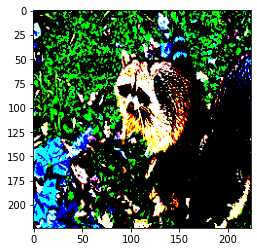

In [38]:
# visualize image
import matplotlib.pyplot as plt
plt.imshow(batch_images_vgg[137])

### Define a vgg16 model and plot the model using plot_model function.
Hint:- Use RepeatVector,Conv1D,GlobalAveragePooling2D(optional to learner)

In [39]:
# getting the model for VGG16
model_vgg = VGG16(input_shape=(img_size, img_size, 3), include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [40]:
# freezing the training layers
for layer in model_vgg.layers:
  layer.trainable = False

In [41]:
# building the models
x2=model_vgg.output
x2=GlobalAveragePooling2D()(x2)
x2=RepeatVector(8)(x2)
x2=Conv1D(4,kernel_size=8,name="coords")(x2)
x2=Flatten()(x2)
model_vgg=Model(inputs=model_vgg.input,outputs=x2)

### Plot the Vgg16 model using plot_model function.

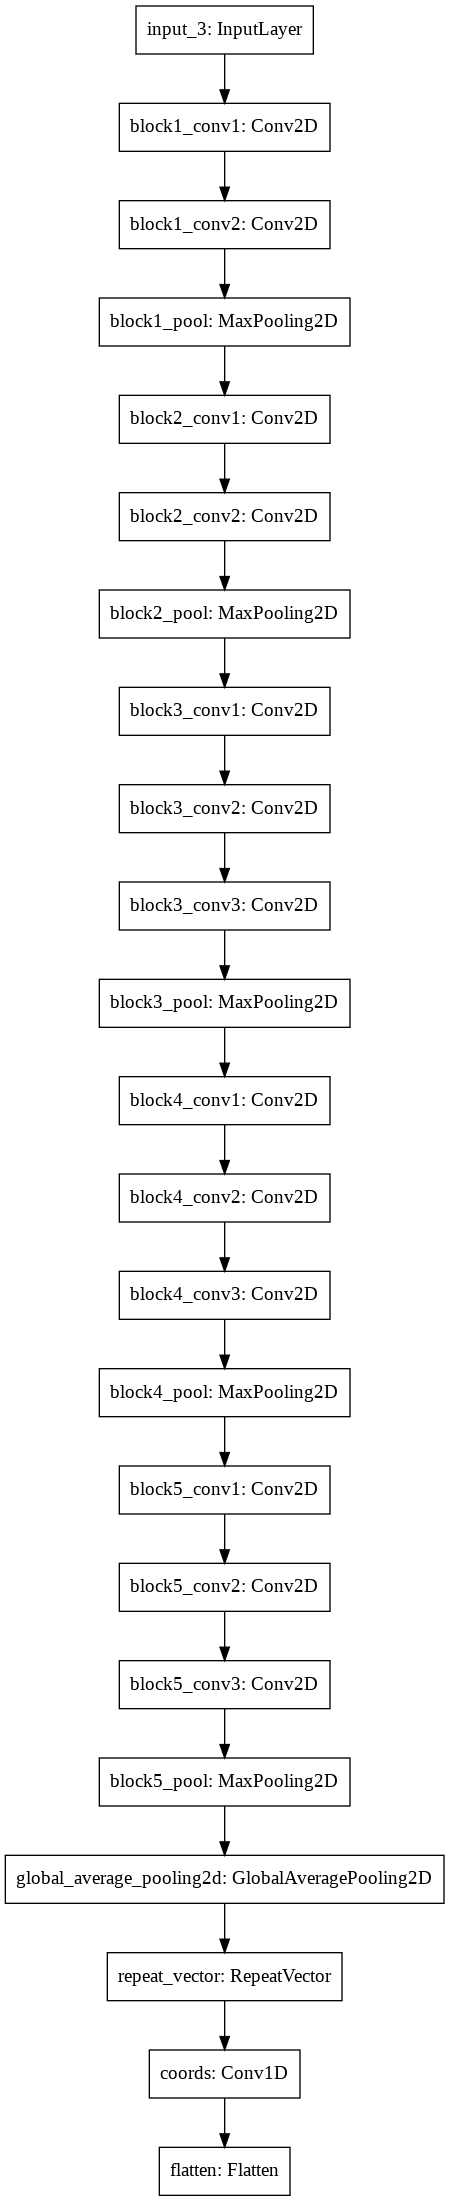

In [42]:
# plotting the model
plot_model(model_vgg)

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [43]:
# compiling the model
model_vgg.compile(optimizer='Adam', loss='mse',  metrics=[IoU])

In [44]:
# fitting the model
model_vgg.fit(batch_images_vgg, coords_vgg, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
6/6 [==============================] - 17s 1s/step - loss: 15047.0732 - IoU: 0.0575
Epoch 2/30
6/6 [==============================] - 1s 228ms/step - loss: 5847.5933 - IoU: 0.2089
Epoch 3/30
6/6 [==============================] - 1s 224ms/step - loss: 2071.8259 - IoU: 0.4321
Epoch 4/30
6/6 [==============================] - 1s 223ms/step - loss: 1853.6608 - IoU: 0.4679
Epoch 5/30
6/6 [==============================] - 1s 227ms/step - loss: 2125.9922 - IoU: 0.4810
Epoch 6/30
6/6 [==============================] - 1s 230ms/step - loss: 1884.4728 - IoU: 0.4985
Epoch 7/30
6/6 [==============================] - 1s 227ms/step - loss: 1528.3607 - IoU: 0.5262
Epoch 8/30
6/6 [==============================] - 1s 227ms/step - loss: 1382.1318 - IoU: 0.5240
Epoch 9/30
6/6 [==============================] - 1s 226ms/step - loss: 1366.0151 - IoU: 0.5137
Epoch 10/30
6/6 [==============================] - 1s 227ms/step - loss: 1314.7368 - IoU: 0.5313
Epoch 11/30
6/6 [=======================

### Pick a test image from the given data

In [51]:
# loading a test image to test
test_img_vgg = Image.open('/content/drive/MyDrive/R10_Internal_Lab/images/raccoon-13.jpg')

# for getting the original image
unscaled_vgg = Image.open('/content/drive/MyDrive/R10_Internal_Lab/images/raccoon-13.jpg')

In [52]:
# getting the height and width of the original image
image_width = unscaled_vgg.size[0]
image_height = unscaled_vgg.size[1]

### Resize the image to 224 * 224 and preprocess the image for the VGG16

In [53]:
# resizing the original image for the VGG16
test_img_vgg = test_img_vgg.resize((img_size, img_size))
test_img_vgg = test_img_vgg.convert(('RGB'))
test_img_vgg = preprocess_input(np.array(test_img_vgg, dtype = np.float32))

### Predict the coordinates of the bounding box for the given test image

In [54]:
# predicting the coordinates
region_vgg = model_vgg.predict(np.array([test_img_vgg]))

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

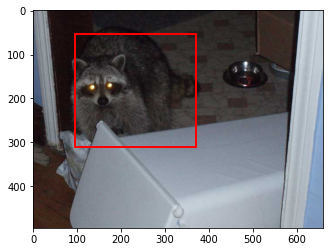

In [56]:
x0 = int(region_vgg[0][0] * image_width / img_size) # Scale the BBox
y0 = int(region_vgg[0][1] * image_height / img_size)

x1 = int((region_vgg[0][2]) * image_width / img_size)
y1 = int((region_vgg[0][3]) * image_height / img_size)


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled_vgg)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()